In [2]:
# Imports
from pathlib import Path
import os
import pickle
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from dataclasses import dataclass
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import resample, decimate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)

In [2]:
# MAKE THE DIRECTORIES FOR SAVING THE PKL DATASET IF THEY DO NOT EXIST
from pathlib import Path

WORKSPACE = Path.cwd()
PKL_DATASET_DIR = WORKSPACE / "pkl_dataset"
SUBJECTS = [f"subj{n:02d}" for n in range(1, 11)]

PKL_DATASET_DIR.mkdir(parents=True, exist_ok=True)
for subj in SUBJECTS:
    (PKL_DATASET_DIR / subj).mkdir(parents=True, exist_ok=True)

print("PKL_DATASET_DIR:", PKL_DATASET_DIR)
print("Created subject subdirs:", ", ".join(SUBJECTS))

PKL_DATASET_DIR: /Users/aidankirwin/Code/Gesture-Recognition/dataset_cleaning/pkl_dataset
Created subject subdirs: subj01, subj02, subj03, subj04, subj05, subj06, subj07, subj08, subj09, subj10


In [3]:
from __future__ import annotations

import os
import pickle
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from dataclasses import dataclass
from pathlib import Path

import numpy as np
from scipy.io import loadmat

WORKSPACE = Path.cwd()
SRC_ROOT = WORKSPACE / 'osfstorage-archive'
DST_ROOT = WORKSPACE / 'pkl_dataset'

SUBJECTS = [f'subj{n:02d}' for n in range(1, 11)]

# Concurrency: tune if you want (I/O + CPU mix).
MAX_WORKERS = min(12, (os.cpu_count() or 4))

# Validation is an extra load of the pickle (but avoids comparing full arrays).
VALIDATE = True

print('SRC_ROOT:', SRC_ROOT)
print('DST_ROOT:', DST_ROOT)
print('MAX_WORKERS:', MAX_WORKERS)
print('VALIDATE:', VALIDATE)

SRC_ROOT: /Users/aidankirwin/Code/Gesture-Recognition/dataset_cleaning/osfstorage-archive
DST_ROOT: /Users/aidankirwin/Code/Gesture-Recognition/dataset_cleaning/pkl_dataset
MAX_WORKERS: 8
VALIDATE: True


In [4]:
def discover_mat_files() -> list[Path]:
    mats: list[Path] = []
    for subj in SUBJECTS:
        subj_dir = SRC_ROOT / subj
        if not subj_dir.exists():
            raise FileNotFoundError(f'Missing subject directory: {subj_dir}')
        mats.extend(sorted(subj_dir.rglob('*.mat')))
    return mats

mat_files = discover_mat_files()
print('Discovered .mat files:', len(mat_files))
print('Example:', mat_files[0] if mat_files else 'None')

Discovered .mat files: 2350
Example: /Users/aidankirwin/Code/Gesture-Recognition/dataset_cleaning/osfstorage-archive/subj01/detop_exp01_subj01_Sess1_01_01.mat


In [5]:
@dataclass
class ConvertResult:
    mat_path: Path
    pkl_path: Path
    ok: bool
    seconds: float
    error: str | None = None

def dst_path_for(mat_path: Path) -> Path:
    # Expect mat_path like .../osfstorage-archive/subjXX/<optional subdirs>/file.mat
    # Mirror any nested subfolders under pkl_dataset/subjXX/... and keep filename.
    parts = mat_path.parts
    try:
        i = parts.index('osfstorage-archive')
    except ValueError:
        raise ValueError(f'Path is not under osfstorage-archive: {mat_path}')

    subj = parts[i + 1]
    if subj not in SUBJECTS:
        raise ValueError(f'Not a supported subject folder: {subj} (path: {mat_path})')

    rel_under_subj = Path(*parts[i + 2 : -1])  # may be '.'
    out_dir = DST_ROOT / subj / rel_under_subj
    return out_dir / (mat_path.stem + '.pkl')

def lightweight_validate(mat_dict: dict, pkl_dict: dict, mat_path: Path) -> None:
    # Keys
    mat_keys = sorted(mat_dict.keys())
    pkl_keys = sorted(pkl_dict.keys())
    if mat_keys != pkl_keys:
        raise ValueError(f'Key mismatch for {mat_path}: MAT has {len(mat_keys)} keys, PKL has {len(pkl_keys)} keys')

    # Types + basic ndarray structure
    for k in mat_keys:
        a = mat_dict[k]
        b = pkl_dict[k]
        if type(a) is not type(b):
            raise TypeError(f'Type mismatch for {mat_path} key={k}: MAT={type(a)} PKL={type(b)}')
        if isinstance(a, np.ndarray):
            if a.shape != b.shape or a.dtype != b.dtype:
                raise ValueError(
                    f'Array mismatch for {mat_path} key={k}: ' 
                    f'MAT shape/dtype={a.shape}/{a.dtype} vs PKL={b.shape}/{b.dtype}'
                )

def convert_one(mat_path: Path) -> ConvertResult:
    t0 = time.perf_counter()
    pkl_path = dst_path_for(mat_path)
    try:
        pkl_path.parent.mkdir(parents=True, exist_ok=True)

        # Load ENTIRE .mat file dict
        mat_dict = loadmat(mat_path)

        # Write pickle
        with open(pkl_path, 'wb') as f:
            pickle.dump(mat_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

        # Lightweight validation (reload pickle, compare keys/types/shape/dtype)
        if VALIDATE:
            with open(pkl_path, 'rb') as f:
                pkl_dict = pickle.load(f)
            lightweight_validate(mat_dict, pkl_dict, mat_path)

        t1 = time.perf_counter()
        return ConvertResult(mat_path=mat_path, pkl_path=pkl_path, ok=True, seconds=t1 - t0)
    except Exception as e:
        t1 = time.perf_counter()
        return ConvertResult(mat_path=mat_path, pkl_path=pkl_path, ok=False, seconds=t1 - t0, error=str(e))

# Run conversion with multi-threading
results: list[ConvertResult] = []
start = time.perf_counter()

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
    futures = {ex.submit(convert_one, mp): mp for mp in mat_files}
    for idx, fut in enumerate(as_completed(futures), start=1):
        res = fut.result()
        results.append(res)
        if idx % 25 == 0 or idx == len(futures):
            ok = sum(r.ok for r in results)
            print(f'Progress: {idx}/{len(futures)} | ok={ok} | failed={idx-ok}')

end = time.perf_counter()
print('Done in %.2f seconds' % (end - start))

Progress: 25/2350 | ok=25 | failed=0
Progress: 50/2350 | ok=50 | failed=0
Progress: 75/2350 | ok=75 | failed=0
Progress: 100/2350 | ok=100 | failed=0
Progress: 125/2350 | ok=125 | failed=0
Progress: 150/2350 | ok=150 | failed=0
Progress: 175/2350 | ok=175 | failed=0
Progress: 200/2350 | ok=200 | failed=0
Progress: 225/2350 | ok=225 | failed=0
Progress: 250/2350 | ok=250 | failed=0
Progress: 275/2350 | ok=275 | failed=0
Progress: 300/2350 | ok=300 | failed=0
Progress: 325/2350 | ok=325 | failed=0
Progress: 350/2350 | ok=350 | failed=0
Progress: 375/2350 | ok=375 | failed=0
Progress: 400/2350 | ok=400 | failed=0
Progress: 425/2350 | ok=425 | failed=0
Progress: 450/2350 | ok=450 | failed=0
Progress: 475/2350 | ok=475 | failed=0
Progress: 500/2350 | ok=500 | failed=0
Progress: 525/2350 | ok=525 | failed=0
Progress: 550/2350 | ok=550 | failed=0
Progress: 575/2350 | ok=575 | failed=0
Progress: 600/2350 | ok=600 | failed=0
Progress: 625/2350 | ok=625 | failed=0
Progress: 650/2350 | ok=650 | f

In [6]:
total = len(results)
ok = sum(r.ok for r in results)
failed = total - ok

print('Total:', total)
print('Succeeded:', ok)
print('Failed:', failed)

if failed:
    print('--- Failures (up to 25) ---')
    for r in [x for x in results if not x.ok][:25]:
        print('MAT:', r.mat_path)
        print('PKL:', r.pkl_path)
        print('ERR:', r.error)
        print('---')

# Basic timing summary (conversion time per file, includes optional validation)
times = np.array([r.seconds for r in results], dtype=float) if results else np.array([], dtype=float)
if times.size:
    print('Mean seconds/file:', float(times.mean()))
    print('Median seconds/file:', float(np.median(times)))
    print('p95 seconds/file:', float(np.quantile(times, 0.95)))

Total: 2350
Succeeded: 2350
Failed: 0
Mean seconds/file: 0.1337179760463496
Median seconds/file: 0.1274758329964243
p95 seconds/file: 0.22476303764269684


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import resample, decimate
import os

"""
Down sample the EMG data and interpolate the glove data
- The EMG data is 2048Hz nxt where n=number of channels (134) and t is number of time points
- The glove data is 256Hz mxt where m=number of joint angles (18) and t is number of time points
"""

ROOT = Path.cwd()
PKL_ROOT = ROOT / 'pkl_dataset'
OUT_ROOT = ROOT / 'pkl_dataset_resampled'  # new output folder (non-destructive)
GLOVE_FS = 256
EMG_FS = 2048
DOWNSAMPLED_EMG_FS = 512
RESAMPLED_GLOVE_FS = DOWNSAMPLED_EMG_FS

#### 1: check data in one file to confirm data shape and available vars
dirs = [entry.name for entry in os.scandir(PKL_ROOT) if entry.is_dir()]

for dir in dirs:
    files = [x for x in os.listdir(PKL_ROOT / Path(dir)) if '.pkl' in x]
    for file in files:
        if 'calibration' in file:
            continue
        df = pd.read_pickle(PKL_ROOT / Path(dir) / Path(file))
        # upsample glove data
        t = np.linspace(0, df['glove'].shape[-1]/GLOVE_FS, df['glove'].shape[-1], endpoint=True)
        upsampled_glove_data = resample(df['glove'], num=int(RESAMPLED_GLOVE_FS/GLOVE_FS)*df['glove'].shape[-1], t=t, axis=1)[0]

        # downsample emg data
        downsampled_emg_data = decimate(df['emg'], q=int(EMG_FS/DOWNSAMPLED_EMG_FS), n=2, axis=1)

        df['emg'] = downsampled_emg_data
        df['glove'] = upsampled_glove_data

        out_dir = OUT_ROOT / dir        # join path with string
        out_dir.mkdir(parents=True, exist_ok=True)

        out_file = out_dir / file

        with out_file.open("wb") as f:
            pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)


In [4]:
"""
Features (from SEED dataset)
"""

def MAV(data):
    """
    :param data: 2D array, channels x samples
    :return: MAV of the data
    """
    return np.mean(np.abs(data), axis=1).reshape((1, data.shape[0]))

def VAR(data):
    """
    Variance
    :param data: 2D array, channels x samples
    :return: Variance of the data
    """
    return np.var(data, axis=1).reshape((1, data.shape[0]))

def RMS(data):
    """
    Root mean square
    :param data: 2D array, channels x samples
    :return: RMS per channel
    """
    return np.sqrt(np.mean(data**2, axis=1)).reshape((1, data.shape[0]))

def zero_crossings(data):
    """
    Number of zero crossings from each channel
    :param data: 2D array, channels x samples
    :return: number of zero crossings for each channel
    """
    positive = data > 0
    return np.sum(np.bitwise_xor(positive[:, 1:], positive[:, :-1]), axis=1).reshape((1, data.shape[0]))

def avg_amplitude_change(data):
    """
    https://www.sciencedirect.com/science/article/pii/S0957417412001200
    :param data: 2D array, channels x samples
    :return: Average amplitude change (AAC) as defined in the reference above
    """
    return np.mean(np.abs(np.diff(data, axis=1)), axis=1).reshape((1, data.shape[0]))

def spectral_centroid(data):
    """
    Spectral Centroid
    :param data: 2D array, channels x samples
    :return: Spectral centroid per channel (FFT-bin based)
    """
    # Magnitude spectrum
    spectrum = np.abs(np.fft.rfft(data, axis=1))
    
    # Frequency bin indices
    freqs = np.arange(spectrum.shape[1])
    
    # Avoid division by zero
    denom = np.sum(spectrum, axis=1) + 1e-12
    
    centroid = np.sum(spectrum * freqs, axis=1) / denom
    return centroid.reshape((1, data.shape[0]))


def spectral_spread(data):
    """
    Spectral Spread
    :param data: 2D array, channels x samples
    :return: Spectral spread per channel (FFT-bin based)
    """
    # Magnitude spectrum
    spectrum = np.abs(np.fft.rfft(data, axis=1))
    
    # Frequency bin indices
    freqs = np.arange(spectrum.shape[1])
    
    # Avoid division by zero
    denom = np.sum(spectrum, axis=1) + 1e-12
    
    # Spectral centroid
    centroid = np.sum(spectrum * freqs, axis=1) / denom
    
    # Spectral spread (standard deviation around centroid)
    spread = np.sqrt(
        np.sum(spectrum * (freqs - centroid[:, None])**2, axis=1) / denom
    )
    
    return spread.reshape((1, data.shape[0]))

In [5]:
import math
import copy
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import resample, decimate
import os

"""
Create a dataset for classification training/testing.
Each participant is stored in a separate file.
"""

def extract_windows(data, num_windows, window_size, window_step):
    windows = []
    for i in range(num_windows):
        start = int(i*window_step)
        end = int(start + window_size)
        win_data = data[:, start:end]
        windows.append(win_data)
    return windows

def num_windows(length, window_size, window_step):
    return int(math.floor((length - window_size) / window_step)) + 1

def extract_features_by_window(data, num_windows, window_size, window_step):
    """
    Splits data set into windows, extracts features for each window
    """

    feature_names = ['mav', 'var', 'rms', 'zcr', 'aac', 'sc', 'ss']

    windows = []
    for i in range(num_windows):
        start = int(i*window_step)
        end = int(start + window_size)
        win_data = data[:, start:end]

        feature_array = []
        feature_array.append(MAV(win_data))
        feature_array.append(VAR(win_data))
        feature_array.append(RMS(win_data))
        feature_array.append(zero_crossings(win_data))
        feature_array.append(avg_amplitude_change(win_data))
        feature_array.append(spectral_centroid(win_data))
        feature_array.append(spectral_spread(win_data))
        
        windows.append(feature_array)
    return windows, feature_names


# file handling
ROOT = Path.cwd()
LABELS = ROOT / 'labels'
DATA = ROOT / 'pkl_dataset_resampled'

# windowing
FS = 512
WINDOW_SIZE = int(0.2*FS)   # 200 ms windows
WINDOW_HOP = WINDOW_SIZE // 2 # 50% overlap (NOTE: WINDOW_HOP = WINDOW_SIZE - WINDOW_OVERLAP)

## Load labels data
labels = pd.read_csv(LABELS / 'labels.csv', index_col=False)
kill_list = pd.read_csv(LABELS / 'kill_list.csv', index_col=False)
kill_list = kill_list['file'].to_list()

## Create empty data frame for all data
dataset_columns = {'movement': [], 'speed': [], 'subject': [], 'session': [], 'trial': [], 'windows_raw': [], 'windows_feature': []}
df = pd.DataFrame(dataset_columns)

## Load in dataset
dirs = [entry.name for entry in os.scandir(DATA) if entry.is_dir()]
for dir in dirs:
    files = [x for x in os.listdir(DATA / dir) if '.pkl' in x]
    for file in files:
        # load data file
        temp = pd.read_pickle(DATA / dir / file)

        if temp['movement'] == 'disc' or temp['movement'] == 'thumbAdd' or file in kill_list:
            continue

        temp_row = dataset_columns.copy()

        # get labels
        file_labs = labels.loc[labels['file'] == file].to_dict(orient='records') # note if this returns more than 1 row something is wrong
        # print(file_labs)
        try:
            file_labs = file_labs[0]
            try:
                start_sample = int(file_labs['start'] * FS)
                end_sample = int(file_labs['end'] * FS)
                # print(f"Start time: {start_sample / FS} | End time: {end_sample / FS}")
            except:
                raise ValueError(f'Could not access start')
        except:
                print(f"Could not find labels for file {file}")
                print(f"Movement: {temp['movement']} | Speed: {temp['speed']}")
        
        if end_sample < start_sample:
            print(f"Start time was less than end time for file {file}")
            print(f"Start time: {start_sample / FS} | End time: {end_sample / FS}")
            print("Continuing to next file")
            continue

        emg = temp['emg']
        emg = emg[:, start_sample:end_sample]

        # extract windows
        n_windows = num_windows(emg.shape[1], WINDOW_SIZE, WINDOW_HOP)
        windows = extract_windows(emg, n_windows, WINDOW_SIZE, WINDOW_HOP)
        feature_windows, feature_names = extract_features_by_window(emg, n_windows, WINDOW_SIZE, WINDOW_HOP)
        ## NOTE: we will need glove data later for regression, leave out for now
        # glove = temp['glove']

        ## append data to dataframe
        temp_row['windows_raw'] = windows
        temp_row['windows_feature'] = feature_windows
        temp_row['speed'] = str(temp['speed'][0])
        temp_row['subject'] = str(temp['subject'][0])
        temp_row['movement'] = str(temp['movement'][0])
        temp_row['session'] = int(temp['session'][0][0])
        temp_row['trial'] = int(str(file).split('.')[0].split('_')[-1])

        df_the_dict = pd.DataFrame([temp_row])
        df = pd.concat([df, df_the_dict], ignore_index=True)

Could not find labels for file detop_exp01_subj02_Sess2_12_05.pkl
Movement: ['middle'] | Speed: ['slow']
Could not find labels for file detop_exp01_subj02_Sess3_02_02.pkl
Movement: ['index_flex'] | Speed: ['fast']
Could not find labels for file detop_exp01_subj03_Sess3_07_04.pkl
Movement: ['cilinder'] | Speed: ['fast']
Could not find labels for file detop_exp01_subj04_Sess2_11_02.pkl
Movement: ['pinch'] | Speed: ['slow']
Could not find labels for file detop_exp01_subj04_Sess1_03_05.pkl
Movement: ['point'] | Speed: ['slow']
Could not find labels for file detop_exp01_subj04_Sess3_02_03.pkl
Movement: ['index'] | Speed: ['fast']
Could not find labels for file detop_exp01_subj04_Sess3_02_02.pkl
Movement: ['index'] | Speed: ['slow']
Could not find labels for file detop_exp01_subj04_Sess1_05_06.pkl
Movement: ['3digit'] | Speed: ['fast']
Start time was less than end time for file detop_exp01_subj04_Sess1_05_01.pkl
Start time: 1.8515625 | End time: 0.6796875
Continuing to next file
Start time w

In [6]:
## save dataset to pkl
df.to_pickle('dataset.pkl')

Let's first reformat the dataset to a 2D array of shape (recordings x features).
Currently, the dataset is a 4D array of shape (recordings x windows x features x channels).

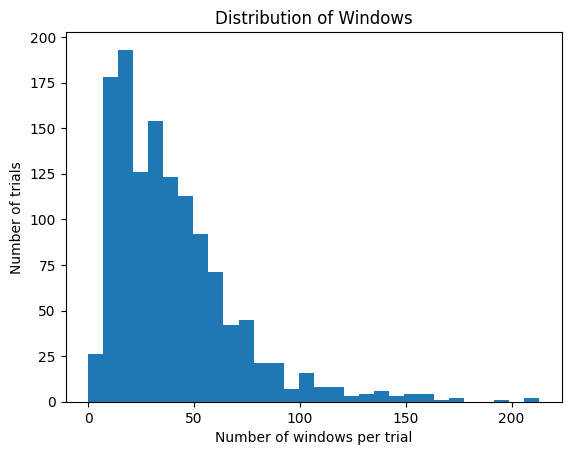

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC

def reshape_data(data, y):
    # Convert X_train to list if it isn't already
    X_list = list(data)  # each element = recording with shape (windows, features, channels)
    y = list(y)

    X_clean = []
    y_clean = []

    for i, rec in enumerate(X_list):
        if np.array(rec).shape[0] > 0:   # keep only recordings with >0 windows
            X_clean.append(np.mean([w for w in rec], axis=0))  # mean across windows
            y_clean.append(y[i])  # keep corresponding label

    # Convert to arrays
    X_mean = np.array(X_clean)  # shape: (recordings_kept, features, channels)
    y_filtered = np.array(y_clean)

    # Optional: flatten for SVM
    X_svm = X_mean.reshape(X_mean.shape[0], -1)
    return X_svm, y_filtered

def plot_trials_histogram(data):
    # Convert pandas Series → list
    data_list = data.to_numpy()   # data is your Series

    # Count windows per trial
    window_counts = [len(trial) for trial in data_list]

    # Plot histogram
    plt.figure()
    plt.hist(window_counts, bins=30)
    plt.xlabel("Number of windows per trial")
    plt.ylabel("Number of trials")
    plt.title("Distribution of Windows")
    plt.show()

dataset = df
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_feature'], dataset['movement'], test_size=0.2, random_state=42)
plot_trials_histogram(X_train)


To start, let's just classify pinch vs fist.

Test accuracy: 96.49%

Classification report:
              precision    recall  f1-score   support

        fist     0.9643    0.9643    0.9643        28
       pinch     0.9655    0.9655    0.9655        29

    accuracy                         0.9649        57
   macro avg     0.9649    0.9649    0.9649        57
weighted avg     0.9649    0.9649    0.9649        57



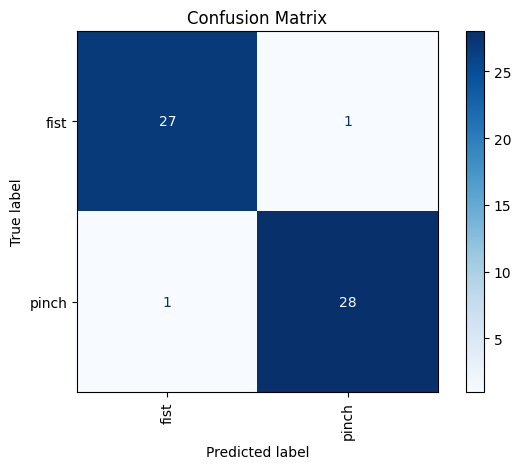

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)

dataset = df
dataset = dataset[dataset['movement'].isin(['pinch', 'fist'])]

X_train, X_test, y_train, y_test = train_test_split(dataset['windows_feature'], dataset['movement'], test_size=0.2, random_state=42)

X_train_svm, y_train = reshape_data(X_train, y_train)
X_test_svm, y_test = reshape_data(X_test, y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svm)
X_train_scaled = scaler.transform(X_train_svm)
X_test_scaled = scaler.transform(X_test_svm)

clf = LinearSVC(random_state=0, max_iter=10000)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc*100:.2f}%")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

# Nice confusion matrix plot with labels + colorbar legend
# after ConfusionMatrixDisplay.from_predictions(...)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=clf.classes_,
    cmap="Blues",
    normalize=None,
    values_format="d",
    colorbar=True,
)

# Rotate the x-axis (bottom) tick labels vertical
ax = disp.ax_
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", va="top")

plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()


Test accuracy: 83.39%

Classification report:
              precision    recall  f1-score   support

      3digit     0.6429    0.8710    0.7397        31
    cilinder     0.9706    0.9167    0.9429        36
        fist     0.8519    0.8519    0.8519        27
       index     0.7586    0.7097    0.7333        31
  index_flex     0.8750    0.9032    0.8889        31
      middle     0.8519    0.6765    0.7541        34
 middle_flex     0.7632    0.9355    0.8406        31
       pinch     0.7143    0.6522    0.6818        23
       point     0.9200    0.8519    0.8846        27
    thumbExt     1.0000    0.9615    0.9804        26
   thumbFlex     0.9474    0.8182    0.8780        22

    accuracy                         0.8339       319
   macro avg     0.8451    0.8316    0.8342       319
weighted avg     0.8440    0.8339    0.8346       319



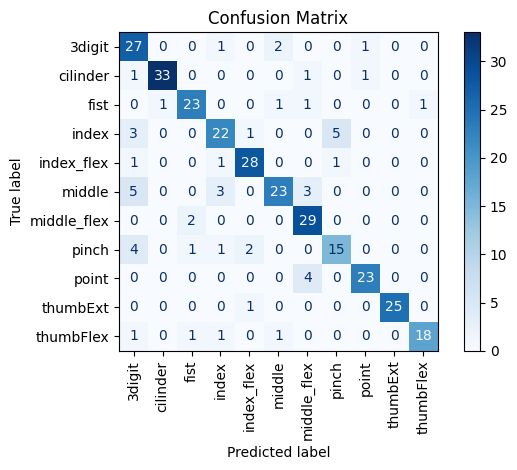

In [18]:
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt

# set up X, y test / train split
dataset = df
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_feature'], dataset['movement'], test_size=0.2, random_state=42)

# reshape
X_train_svm, y_train = reshape_data(X_train, y_train)
X_test_svm, y_test = reshape_data(X_test, y_test)

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svm)
X_train_scaled = scaler.transform(X_train_svm)
X_test_scaled = scaler.transform(X_test_svm)

# clf = LinearSVC(C=1.0, class_weight="balanced", max_iter=20000, random_state=0)
clf = SVC(C=10.0, kernel="rbf", gamma="scale", class_weight="balanced")
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc*100:.2f}%")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

# Nice confusion matrix plot with labels + colorbar legend
# after ConfusionMatrixDisplay.from_predictions(...)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=clf.classes_,
    cmap="Blues",
    normalize=None,
    values_format="d",
    colorbar=True,
)

# Rotate the x-axis (bottom) tick labels vertical
ax = disp.ax_
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", va="top")

plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

Now let's do CNN.

In [ ]:
dataset = pd.read_pickle('dataset.pkl')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_raw'], dataset['movement'], test_size=0.2, random_state=42)

print(X_train.shape)
data = X_train

# 


(1274,)
(1274,)
68
(134, 102)
(102,)
